# *Chandra* results for Osase's SDSS 1531 Paper 

## 0. A summary of how these data products were created: 

G. Tremblay made these for Osase using the *Chandra Cluster Cosmology Project IV* codes from Tremblay & Vikhlinin et al. 2022 in prep. These codes can be a hugely complex spaghetti-ball of 60+ individual perl and python scripts, and so it's far easier to have me reduce and run the data than have Osase do it. For the record, these are the CCPIV codebase commands I used to reduce Osase's data. Osase: I'm happy to explain all of this, and even help you install it on your machine - but trust me, it's just not worth the pain right now, all we really need is a good Temperature and surface brightness profile. CCCPIV does this with *far* greater care than e.g. the CIAO thread explaining how to obtain and fit a radial SB profile.  

```
Working in ~/100/Osase_Cluster/SDSS1531

Create cluster.par with these contents: 


name = SDSS1531+3414
common_name = SDSSJ1531+3414CLUSTER
useobs = 17218,18689
ra = 15h31m106s
dec = 34d14m25.0s
z = 0.335
nh = 1.79E+20
rax = 232.794243
decx = 34.240245
prof_min_area=0.5

######################
# prof_min_area=0 resulted in a divide by zero error during mk_profiles

cd ~/100/Osase_Cluster

~/100/bin/run_command download_data *
~/100/bin/run_command clone_obsids *
~/100/bin/reduce_cluster --stop_at_lcclean *
~/100/python-scripts/copy_lc_clean_pdfs.py

#On your Desktop, in the lcclean_plots folder, check the results. 


# We see that there is a large flare in 18689, and that lc_clean has done a very poor job of flagging it (it catches the peak and, but not the rise). So let's redo it with AV's script. 

cd SDSS1531

~/100/bin/redo_fi_flare_gti 17218_fi
~/100/bin/redo_fi_flare_gti 18689_fi

~/100/bin/redo_bi_flare_gti 17218_bi
~/100/bin/redo_bi_flare_gti 18689_bi

# clean up the directories 

rm -rf 17218
rm -rf 18689

# the new GTIs have been copied back to 17218_bi, and 18689_bi
# but the FI script doesn't do this, you need to do that manually

mv 17218_fi.save 17218_fi
mv 18689_fi.save 18689_fi

rm -rf 17218_bi_adjgti
rm -rf 17218_fi_adjgti
rm -rf 18689_bi_adjgti
rm -rf 18689_fi_adjgti

cd ..

# I checked the new gti[1-9].fits files, gti1.fits is good in every case

~/100/bin/run_command_on_obsids setup_pad *
#in each process.par, you must update gtifile=gti1.fits
# oops, there's no process.par because do_clean_flares happens just before setup_pad
# just run in manually!


~/100/bin/reduce_cluster --stop_at_lcclean --force_lcclean *
vger &
run_command locate_center *
~/100/bin/reduce_cluster --stop_at_bg *
~/100/bin/run_command_on_obsids examine_bg_norms * # just to look at it again
~/100/bin/run_command_on_obsids check_bg_cal * # nothing is below 0.2, I think we're okay 

~/100/bin/reduce_cluster *

# it worked! We are now done with reduce_cluster

# check the source masks: 

vger &
run_command examine_src_masks *

# look good, no action needed

# Now from the "protocol for analyze_clusters" trello card: 


~/100/bin/run_command setup_bg_regs *
vger &
~/100/bin/run_command mark_bg_regs *


# move the annulus such that it encompasses appropriate local background. It's okay if it goes off the chip a bit

~/100/bin/analyze_cluster --skip_profiles --stop_at_bgfit *

open SDSS1531/spectra/bgfit.pdf

# looks pretty good to me, I'm not sure we need to do any fiddling here, dont see any cluster excess

~/100/bin/analyze_cluster --skip_profiles --stop_at_nh *

open SDSS1531/spectra/nH.pdf
# looks really good to me! 

# now in ~/100/Osase_Cluster/SDSS1531/fitprof
vim fitprof.par
# add this line: 
rmin=1 // kpc

# Now rerun everything up to computing and fitting T- and abundance profiles
cd ~/100/Osase_Cluster
~/100/bin/analyze_cluster --skip_masses --skip_profiles *

open SDSS1531/spectra/Tprof/tprof.pdf

# looks good, BUt has a "step" at the tcool Add this to Tprof/trpof.par
T_acool=1.0
fit_T_acool=no

# Looks great!! 


# FINALLY: 
~/100/bin/analyze_cluster *

# look at the fits in fitprof, etc. 
# copy relevant products for analysis

cp SDSS1531/fitprof/tot.fit.2 /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.dat /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.par /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/spectra/Tprof/tprof.rbounds /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles

cp -r SDSS1531/profiles/prof.700-2000.* /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles
cp SDSS1531/masses.par /Users/grant/beads/Notebooks/Beads20/Chandra/final_cccp4_profiles


# load profile regions like this: 

vger &
vger -X load SDSS1531/images/ff.img.07-2.gz
vger -X cmap magma
vger -X GaussBlurData, 2.0
vger -X LoadRegions SDSS1531/regs/tprof.reg

or 
vger -X LoadRegions SDSS1531/regs/bg.reg
vger -X LoadRegions SDSS1531/regs/tspec0.reg

```

## 1. Analysis of those data products!

#### Imports

In [1]:
import os 
import glob
from types import SimpleNamespace # cute trick to turn dictionaries into separate variables

import numpy as np

from astropy.io import ascii
from astropy.table import Table

from astropy import units as u
from astropy.cosmology import FlatLambdaCDM


import matplotlib.pyplot as plt
import seaborn as sns

%config InlineBackend.figure_format='retina'
plt.style.use('ggplot')
# sns.set_theme(context = 'talk') # feel free to fiddle with the aesthetics of the plots to your liking, Osase

#### Set up cosmology

In [2]:
z = 0.335 # best redshift for SDSS 1531
cosmo = FlatLambdaCDM(H0=70, Om0=0.3, Tcmb0=2.725)
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=z).to(u.kpc / u.arcsec)
print(f'At a redshift of {z}, we have {np.round(kpc_per_arcsec,4)}')

At a redshift of 0.335, we have 4.7998 kpc / arcsec


#### Directory structure

In [3]:
profiles_dir = 'final_cccp4_profiles/'
plot_save_directory = 'final_plots/'
print('These are the data products GT manually copied from various CCCPIV directories: ')
os.listdir(profiles_dir)

These are the data products GT manually copied from various CCCPIV directories: 


['final_temperature_profile.dat',
 'temperatures.par',
 'prof.700-2000.17218_bi.flat.spec',
 'tprof.dat',
 'tot.fit.2',
 'prof.700-2000.18689_bi.flat.spec',
 'prof.700-2000.18689_fi.flat',
 'masses.par',
 'tprof.rbounds',
 'prof.700-2000.18689_bi.flat',
 'temperature_profile_regions.png',
 'totprof.700-2000',
 'accept_main_table.txt',
 'prof.700-2000.17218_bi.flat',
 'prof.700-2000.17218_fi.flat.spec',
 'prof.700-2000.17218_fi.flat',
 'tprof.par',
 'prof.700-2000.18689_fi.flat.spec']

#### Functions for this section: 

In [4]:
with open(profiles_dir + 'masses.par') as r:
    lines = r.read().splitlines()

print(lines)

['M500_Y = 2.386E+14', 'eM500_Y = 1.259e+13', 'R500_Y = 840.0', 'eR500_Y = 14.8', 'M500_G = 2.763E+14', 'eM500_G = 1.189e+13', 'R500_G = 882.0', 'eR500_G = 12.5', 'M500_n = 2.699E+14', 'eM500_n = 1.142e+13', 'R500_n = 875.2', 'eR500_n = 12.2']


In [5]:
def parse_sbprof_parfile(tot_fit_file):
    '''read tot.fit.2 file and populate a dictionary of the relevant fit parameters. 
    The first 87 lines or so are the actual ne*np profiles. 
    Need to check that 93:105 is consistent across all tot.fit.2 files for full CCCPIV 
    implementation'''
    
    with open(profiles_dir + 'tot.fit.2') as r:
        # I *think* [93:105] is consistent across all tot.fit.2 files
        lines = r.read().splitlines()[93:105]

        sbprof_par_dict = {}
        
        for line in lines:

            # These splits have a ton of whitespace so this is easier way to do it
            pair= [x.strip() for x in line.split('//')[0].split(' = ')]
            
            sbprof_par_dict[pair[0]] = float(pair[1])

    return sbprof_par_dict

def parse_tprof_parfile(tprof_parfile):
    
    '''read tprof.par from CCCPIV and parse it'''
    
    tprof_par_dict = {}
    
    with open(tprof_parfile) as f:
        lines = f.read().splitlines() 
    
    for line in lines:
        pair = line.split(' = ')
        
        if pair == ['fit_T_acool=no']:
            continue
        
        tprof_par_dict[pair[0]] = float(pair[1])
    
    return tprof_par_dict


def parse_mass_parfile(mass_parfile):

    mass_par_dict = {}

    with open(mass_parfile) as r:
        lines = r.read().splitlines()

    for line in lines:
        pair = line.split(' = ')
        mass_par_dict[pair[0]] = float(pair[1])

    return mass_par_dict
    
    

def vikhlinin_ne_np_fit(sbprof_pars: dict, radius_array=None): 

    # This simply implements eq. (2) in Vikhlinin et al. (2009) (CCCPII paper)
    # allow the user to pass their own radius array if they'd like 

    n = SimpleNamespace(**sbprof_pars) # converting a dictionary into namespace 

    if radius_array is None:
        radius = np.arange(0,5000,1)
    elif radius_array is not None:
        radius = radius_array
        
    ne_np = n.n0**2 * ((radius / n.rc)**-n.alpha)/ (1 + (radius**2 / n.rc**2))**(3*n.beta-n.alpha/2) * 1 / ((1 + (radius**n.gamma / n.rs**n.gamma))**(n.epsilon/n.gamma)) + (n.n02**2 / (1 + (radius**2/n.rc2**2))**(3*n.beta2))
    return r, ne_np
    

def vikhlinin_temperature_fit(tprof_pars: dict, radius_array=None):

    ''' This is the famous Vikhlinin et al. (2006) analytic multi-component temperature profile fit to a sample of galaxy clusters. 
    It takes into acccount things like cool cores, etc. 
    
    '''
    
    # We need this dictionary's key/value pairs to become variables we can use directly (otherwise we need to query the dictionary every time, which is too much text). 
    
    n = SimpleNamespace(**tprof_pars) # converting a dictionary into namespace 
    
    ''''''
    if radius_array is None:
        #tfit_radius = [float(pow(10.0,(i-1)*3.6/999.0)) for i in list(range(1,1000))]
        tfit_radius = np.arange(0,5000,1)
    elif radius_array is not None:
        tfit_radius = radius_array

    a = tfit_radius / n.T_rt
    tmain = pow(a,-n.T_a)/pow((1+pow(a,n.T_b)),(n.T_c/n.T_b))

    b = pow(tfit_radius/n.T_rcool,n.T_acool)
    tcool = (b+n.T_tmin)/(b+1)
    tfit_t = n.T0*tcool*tmain

    return np.array(tfit_radius),np.array(tfit_t)


def coolingFunction(kT):
    """
    Implement the Tozzi & Norman (2001) cooling function.
    This is an analytic fit to Sutherland & Dopita (1993), shown
    in Equation 16 of Parrish, Quataert, & Sharma (2009),
    as well as Guo & Oh (2014).
    See here: arXiv:0706.1274. The equation is:
    $\Lambda(T) = [C_1 \left( \frac{k_B T}{\mathrm{keV}} \right)^{-1.7}
                  + C_2\left( \frac{k_B T}{\mathrm{keV}} \right)^{0.5}
                  + C_3] \times 10^{-22}$
    """
    # For a metallicity of Z = 0.3 Z_solar,
    C1 = 8.6e-3
    C2 = 5.8e-2
    C3 = 6.3e-2

    alpha = -1.7
    beta = 0.5

    coolingFunction_raw = C1*kT**alpha + C2*kT**beta + C3

    coolingFunction = coolingFunction_raw * 1.0e-22 # putting it in CGS

    return coolingFunction


In [7]:
def parse_accept_table(accept_table_file):

    accept_table_raw = ascii.read(accept_table_file)

    accept_table_grouped = accept_table_raw.group_by('Name')
    return accept_table_grouped

accept_table = parse_accept_table(profiles_dir + 'accept_main_table.txt')
accept_table

Name,Rin,Rout,nelec,neerr,Kitpl,Kflat,Kerr,Pitpl,Pflat,Perr,Mgrav,Merr,Tx,Txerr,Lambda,tcool5/2,t52err,tcool3/2,t32err
str18,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
1E0657_56,1.1735,1.1945,0.00028571,1.9911e-05,2267.2,2267.2,631.23,4.552e-12,4.552e-12,1.2892e-12,6471500000000000.0,1302800000000000.0,10.116,2.9178,2.6682e-23,387.38,114.95,232.43,68.972
1E0657_56,1.1526,1.1735,0.00037185,4.2443e-05,1858.2,1858.2,507.28,5.7884e-12,5.7884e-12,1.6551e-12,-437240000000000.0,-84063000000000.0,9.8517,2.7081,2.6265e-23,294.48,87.65,176.69,52.59
1E0657_56,1.1316,1.1526,0.00036489,4.4078e-05,1837.6,1837.6,481.28,5.5467e-12,5.5467e-12,1.5362e-12,-1631600000000000.0,-298190000000000.0,9.5879,2.4985,2.5848e-23,296.76,85.238,178.06,51.143
1E0657_56,1.1107,1.1316,0.00033859,4.5086e-05,1885.0,1885.0,474.68,5.023e-12,5.023e-12,1.3596e-12,1338200000000000.0,231260000000000.0,9.3241,2.2888,2.5431e-23,316.12,88.281,189.67,52.968
1E0657_56,1.0897,1.1107,0.00045308,6.4837e-05,1514.1,1514.1,364.98,6.5557e-12,6.5557e-12,1.7281e-12,1041300000000000.0,169060000000000.0,9.0603,2.0792,2.5014e-23,233.38,63.115,140.03,37.869
1E0657_56,1.0687,1.0897,0.00041445,6.1114e-05,1617.1,1617.1,382.67,6.0356e-12,6.0356e-12,1.5748e-12,585550000000000.0,92427000000000.0,8.9078,1.9255,2.4739e-23,253.63,66.367,152.18,39.82
1E0657_56,1.0478,1.0687,0.00045547,5.2383e-05,1550.6,1550.6,351.28,6.7727e-12,6.7727e-12,1.6405e-12,1387500000000000.0,216920000000000.0,9.1061,1.9484,2.4907e-23,234.34,56.925,140.6,34.155
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ZwCl_0857.9+2107,0.11081,0.12928,0.0031813,0.00087316,145.87,145.87,30.349,1.6261e-11,1.6261e-11,4.7447e-12,27820000000000.0,2020600000000.0,3.2398,0.38822,1.7143e-23,17.343,5.1939,10.406,3.1163


In [8]:
mass_results = parse_mass_parfile(profiles_dir + 'masses.par')
mass_results

{'M500_Y': 238600000000000.0,
 'eM500_Y': 12590000000000.0,
 'R500_Y': 840.0,
 'eR500_Y': 14.8,
 'M500_G': 276300000000000.0,
 'eM500_G': 11890000000000.0,
 'R500_G': 882.0,
 'eR500_G': 12.5,
 'M500_n': 269900000000000.0,
 'eM500_n': 11420000000000.0,
 'R500_n': 875.2,
 'eR500_n': 12.2}

In [9]:
sbprof_par_dict = parse_sbprof_parfile(profiles_dir + 'tot.fit.2')
tprof_par_dict = parse_tprof_parfile(profiles_dir + 'tprof.par')

(sbfitx, sbfity) = vikhlinin_ne_np_fit(sbprof_par_dict)
(tfitx, tfity) = vikhlinin_temperature_fit(tprof_par_dict)

/var/folders/s_/7v014tss6d18cgg702db9d5r0000gn/T/ipykernel_31888/2681326608.py:69: RuntimeWarning: divide by zero encountered in power
  ne_np = n.n0**2 * ((radius / n.rc)**-n.alpha)/ (1 + (radius**2 / n.rc**2))**(3*n.beta-n.alpha/2) * 1 / ((1 + (radius**n.gamma / n.rs**n.gamma))**(n.epsilon/n.gamma)) + (n.n02**2 / (1 + (radius**2/n.rc2**2))**(3*n.beta2))


In [10]:
sbprof_par_dict

{'pix2kpc': 9.4462032,
 'n0': 0.0106308,
 'rc': 55.863,
 'rs': 622.306,
 'alpha': 1.3911,
 'beta': 0.4431,
 'gamma': 3.0,
 'epsilon': 4.7062,
 'n02': 0.0393043,
 'rc2': 63.449,
 'beta2': 2.8,
 'bg': 0.0}

#### Preliminary read-in and needed calculations for the temperature profile & fit

Read in the main temperature profile as an Astropy Table

In [9]:
tprof_datfile_names = ['Bin', 'T(keV)', 'Terr-', 'Terr+', 'Terr-90percent', 'Terr+90percent', 'Abundance (solar)', 'Abundance_err (solar)', 'nH (1e20 cgs)', 'nH_err (1e20 cgs)', 'T syserr bkg', 'T syserr foregrd', 'G9']
tprof = ascii.read(profiles_dir+'tprof.dat', names=tprof_datfile_names)

This is the table of best-fit parameters from CCCPIV. Parse it into a dictionary. 

Calculate the Vikhlinin+09 analytic fit to the temperature profile using these best-fit parameters (for plotting it)

Finally, calculate the radius of each annulus in kpc (for plotting)

In [10]:
# This file includes the inner and outer annuli for the temperature profile bins
# you need to include data_end because tprof is usually smaller by a few outer bins
radii_bounds_names = ['BIN', 'RIN', 'ROUT']
radii_bounds = ascii.read(profiles_dir + 'tprof.rbounds', names=radii_bounds_names, data_end = len(tprof['Bin']))

# Calclate the bin center from 
bin_center_radius_kpc = ((radii_bounds['RIN'] + radii_bounds['ROUT']) / 2)* u.arcsec * kpc_per_arcsec
bin_center_radius_err_kpc = ((radii_bounds['ROUT'] - radii_bounds['RIN']) / 2)* u.arcsec * kpc_per_arcsec

The profile annuli look like this, by the way: 

<img src="final_cccp4_profiles/temperature_profile_regions.png" alt="regions" width="600"/>


Plot the temperature profile, fit, and other relevant metadata (for publication!)

In [11]:
len(tprof['T(keV)'])

10

Text(0.5, 0, 'Radius (kpc)')

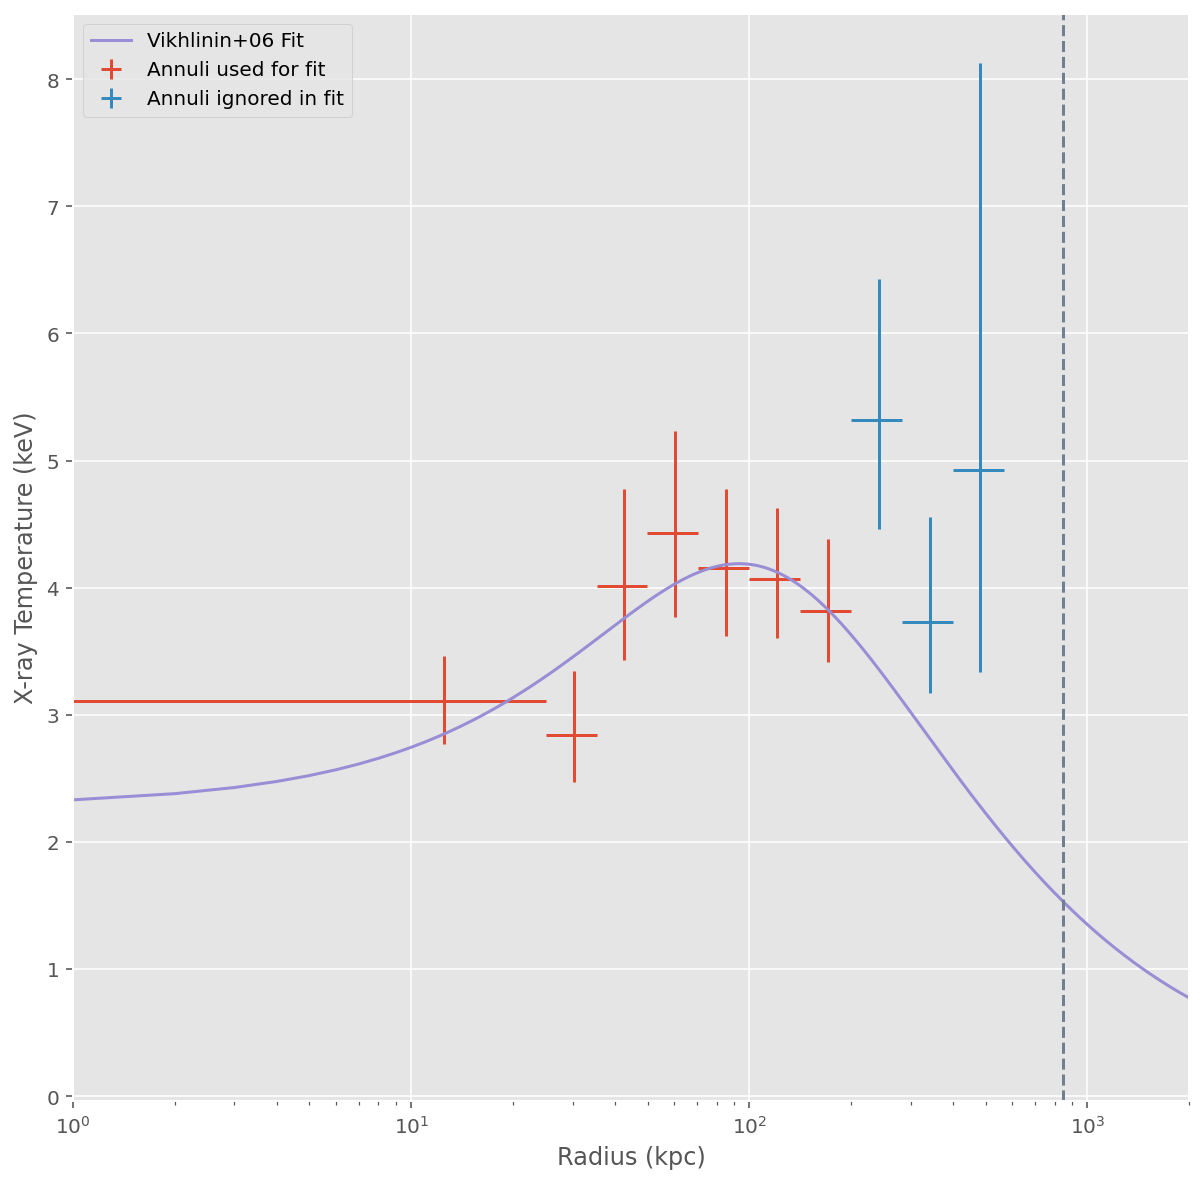

In [12]:
fig, ax = plt.subplots(figsize=(10,10))

last_fit_annulus = 7
last_valid_annulus = len(tprof['T(keV)']) # I only fit the temperature profile using data points from the first 7 annuli

ax.errorbar(bin_center_radius_kpc[:last_fit_annulus], tprof['T(keV)'][:last_fit_annulus], yerr=[-tprof['Terr-'][:last_fit_annulus], tprof['Terr+'][:last_fit_annulus]], xerr=bin_center_radius_err_kpc[:last_fit_annulus], ls='none', label='Annuli used for fit')
ax.errorbar(bin_center_radius_kpc[last_fit_annulus:], tprof['T(keV)'][last_fit_annulus:], yerr=[-tprof['Terr-'][last_fit_annulus:], tprof['Terr+'][last_fit_annulus:]], xerr=bin_center_radius_err_kpc[last_fit_annulus:], ls='none', label='Annuli ignored in fit')
ax.plot(tfitx,tfity, label='Vikhlinin+06 Fit')
ax.set_xscale('log')
ax.set_xlim(1,2000)

r500 = 848.6 # kpc
ax.axvline(r500, color='slategray', ls='--') # R_500 from the CCCPIV best fit. 

ax.legend()
ax.set_ylabel('X-ray Temperature (keV)')
ax.set_xlabel('Radius (kpc)')


The power emitted per cubic cm per second (i.e., $\mathrm{erg}~\mathrm{s}^{-1}$ $\mathrm{cm}^{-3}$) of a fully ionized plasma emitting "free-free" / thermal bremsstrahlung radiation is given by 

$\epsilon^{ff} \equiv 1.4 \times 10^{-27} T^{1/2} n_e n_i Z^2 \bar{g}_B$,

where $1.4\times10^{-27}$ comes from integrating over the power per unit area per unit frequency (and includes things like the Boltzmann constant, see eq. 1.3 of Cavagnolo's PhD thesis), $n_e$ and $n_i$ are the electrion and ion densities, $Z$ is the number of protons of the bending charge, and $\bar{g}_B$ is the frequency averaged Gaunt factor, and $T$ is the global temperature determined from the spectral cut-off frequency. Because free-free emission is a two-body process, the emission goes as gas density squared and has a weak dependence on the thermal energy, i.e. $\epsilon \propto \rho^2 T^{1/2}$ for $T \geq 10^7$ K. 

Now, look at that equation above. The power emitted is the thing we detect with \textit{Chandra}, essentially. It is directly coupled to fundamentally two properties: temperature and density.

In fact, it directly follows that observing 

$\eta = \frac{10^{-14}}{4\pi D_A^2(1+z)^2} \int n_e n_p dV$

#### Read in the surface brightness profiles (data)

In [13]:

# c2e means "counts to emission measure" - yes, this is bad ambiguous naming and I don't recommend it. 

sb_profile_names = ['RIN', 'ROUT', 'IGNORE1', 'IGNORE2', 'SUR_BRI', 'SUR_BRI_ERR']
c2e_names = ['RIN', 'ROUT', 'R_KPC', 'C2EMM', 'GOV5', 'GOV6', 'GOV7', 'GOV8', 'GOV9', 'GOV10', 'GOV11']

sb_profile_17218_bi = ascii.read(profiles_dir + 'prof.700-2000.17218_bi.flat', names=sb_profile_names)
sb_profile_17218_fi = ascii.read(profiles_dir + 'prof.700-2000.17218_fi.flat', names=sb_profile_names)
sb_profile_18689_bi = ascii.read(profiles_dir + 'prof.700-2000.18689_bi.flat', names=sb_profile_names )
sb_profile_18689_fi = ascii.read(profiles_dir + 'prof.700-2000.18689_fi.flat', names=sb_profile_names )

counts2emm_sb_profile_17218_bi = ascii.read(profiles_dir + 'prof.700-2000.17218_bi.flat.spec', names=c2e_names)
counts2emm_sb_profile_17218_fi = ascii.read(profiles_dir + 'prof.700-2000.17218_fi.flat.spec', names=c2e_names)
counts2emm_sb_profile_18689_bi = ascii.read(profiles_dir + 'prof.700-2000.18689_bi.flat.spec', names=c2e_names)
counts2emm_sb_profile_18689_fi = ascii.read(profiles_dir + 'prof.700-2000.18689_fi.flat.spec', names=c2e_names)

# including the front-illuminated chips, which are WAY outside of the cluster and basically all background

# profiles = [sb_profile_17218_bi, sb_profile_17218_fi, sb_profile_18689_bi, sb_profile_18689_fi]
# c2etables = [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_17218_fi, counts2emm_sb_profile_18689_bi, counts2emm_sb_profile_18689_fi]

# BI chips only (i.e. the nominal aimpoint )
profiles = [sb_profile_17218_bi, sb_profile_18689_bi]
c2etables = [counts2emm_sb_profile_17218_bi, counts2emm_sb_profile_18689_bi]
obsids = ["ObsID 17218", "ObsID 18689"]




#### Read in the surface brightness profile fit

In [14]:
sb_profile_fit_names = ['R', # radius in kpc, r=(r1+r2)/2 where r1 and r2 are the inner and outer radii of the annulus
                        'FIT', # Emission measure,  E=\int ne np dl, in units of cgs per kpc^2 (sorry :). E.g., you need to divide these numbers by 9.52141e+42 (i.e. kpc^2 in cm) to get to the cgs units. C.f. CCCP2 fig5.
                        'ne_np', # np * ne at radius r (cgs)
                        'sqrt(ne_np)', # sqrt(ne*np) at radius r (cgs units)
                        'outer_annulus_r', #r2 (outer annulus radius) in kpc, cf col 1
                        'gas_mass', # gas mass within r < r2, Msolar
                        'spherical_overdensity'] # Spherical overdensity of the gas mass with respect to the mean cosmic density of baryons.

sb_profile_fit = ascii.read (profiles_dir + 'tot.fit.2',
                           names = sb_profile_fit_names,
                           data_end=87)

Text(0.5, 1.0, 'Cluster X-ray Surface Brightness Profile')

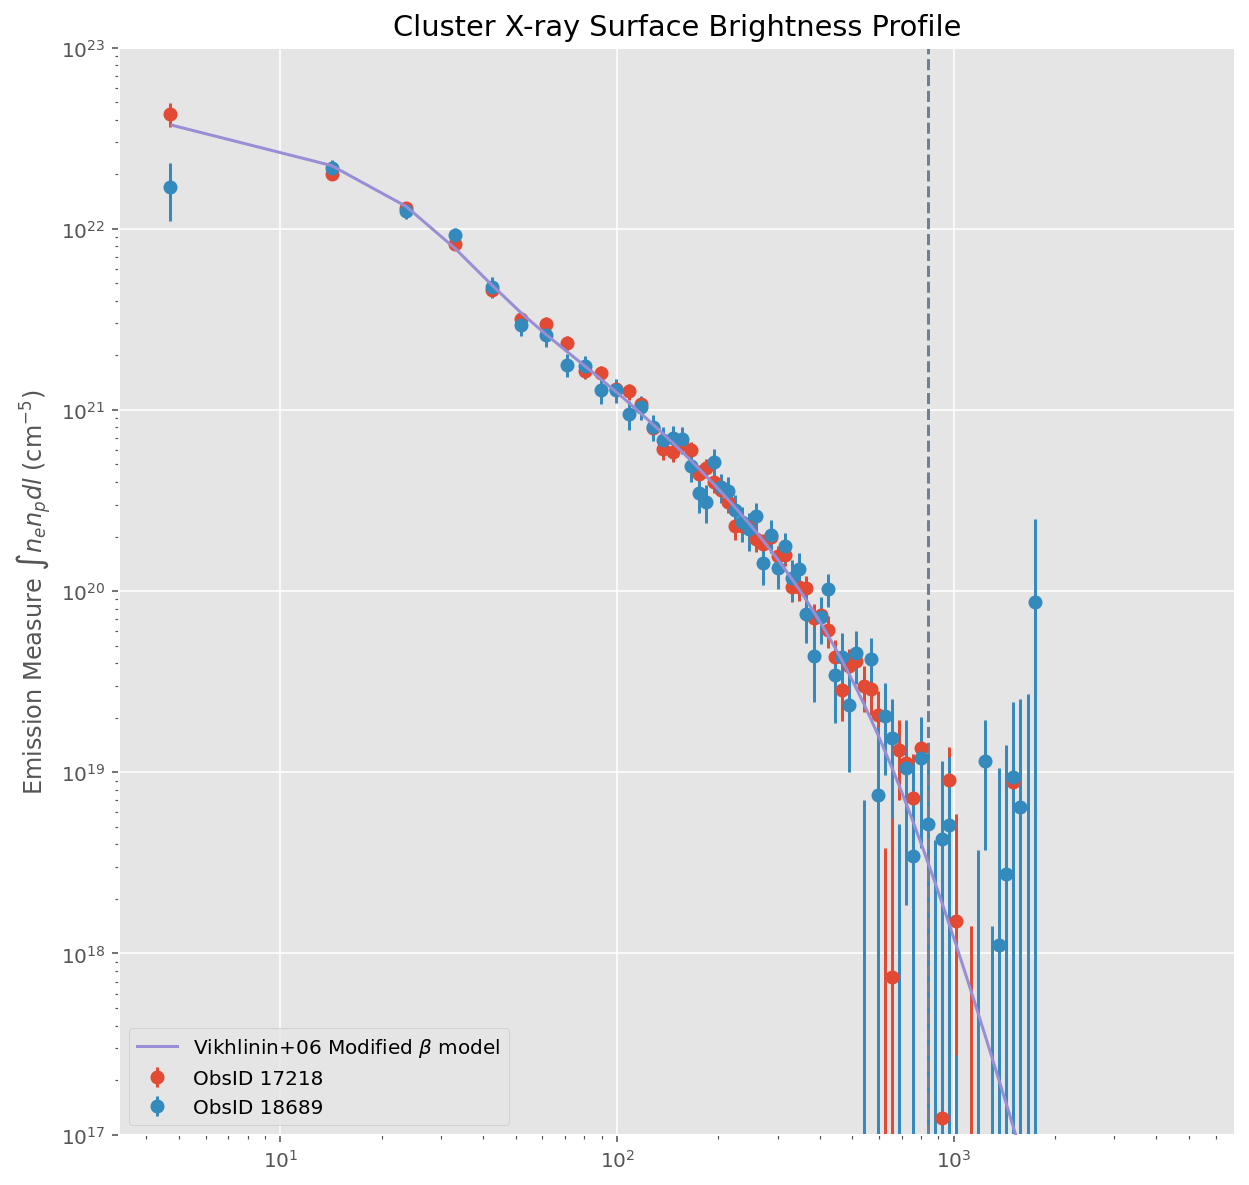

In [15]:
fig, ax = plt.subplots(figsize=(10,10))

for i, profile in enumerate(profiles):

    x = c2etables[i]['R_KPC']
    y = (profile['SUR_BRI']  * c2etables[i]['C2EMM'] - sbprof_par_dict['bg']) / 9.52141e+42 # this factor is cm2 per kpc2
    err = (profile['SUR_BRI_ERR'] * c2etables[i]['C2EMM']) / 9.52141e+42

    ax.errorbar(x,y, yerr=err, ls='none', marker='o', label=obsids[i])

sb_fit_x = sb_profile_fit['R'] 
sb_fit_y = sb_profile_fit['FIT']/ 9.52141e+42

    
ax.plot(sb_fit_x, sb_fit_y, zorder=3, label=r'Vikhlinin+06 Modified $\beta$ model')

ax.legend()
ax.set_ylabel(r'Emission Measure $\int n_e n_p dl$ (cm$^{-5}$)')
ax.set_yscale('log')
ax.set_xscale('log')
ax.axvline(mass_results['R500_Y'], color='slategray', ls='--', lw=1.5) # R_500 from the CCCPIV best fit.
ax.set_ylim(1e17,1e23)
# ax.set_xlim(-400, 1800)
ax.set_title("Cluster X-ray Surface Brightness Profile")

# ax2.set_yscale('log')
# ax2.set_xscale('log')




In [51]:
# make radius that goes all the way to 0 kpc
full_radius = np.arange(0,1000,1)
tfit_r, tfit_y = vikhlinin_temperature_fit(tprof_par_dict, full_radius)


In [86]:
def fit_polynomial_to_accept(desired_radius, thing_to_fit_radius, thing_to_fit):
    ln_r = np.log(thing_to_fit_radius)
    ln_desired_radius = np.log(desired_radius)
    ln_thing_to_fit = np.log(thing_to_fit)
    coeffs = np.polynomial.polynomial.polyfit(ln_r, ln_thing_to_fit, deg=3)

    ln_fit = np.polynomial.polynomial.polyval(ln_desired_radius, coeffs)

    fit = np.exp(ln_fit)

    return desired_radius, fit
    

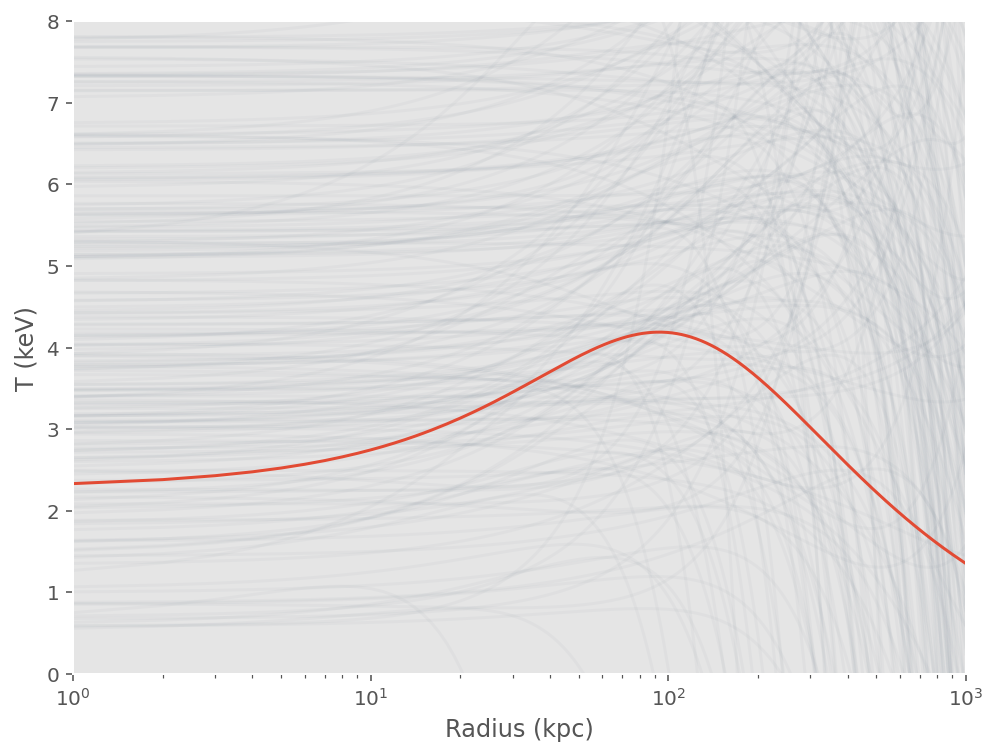

In [99]:

fig, ax = plt.subplots(figsize=(8,6))
ax.plot(tfit_r, tfit_y)
# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('T (keV)')
ax.set_xlabel('Radius (kpc)')

# underplot the cooling time profiles for all accept clusters as a comparison! 
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc


    coeffs = np.polynomial.polynomial.polyfit(accept_radius, cluster_profile['Tx'], deg=2)
    accept_fit = np.polynomial.polynomial.polyval(tfit_r, coeffs)
    
    ax.plot(tfit_r, accept_fit, label=cluster_name, color='slategray', alpha=0.05, zorder=0)
    
    # ax.plot(accept_radius, cluster_profile['Tx'] , label=cluster_name, zorder=1, alpha=0.05, color='gray', lw=0, marker='o',  markersize=0.6)


ax.set_ylim(0,8)
ax.set_xlim(1, 1000)
ax.grid(False)



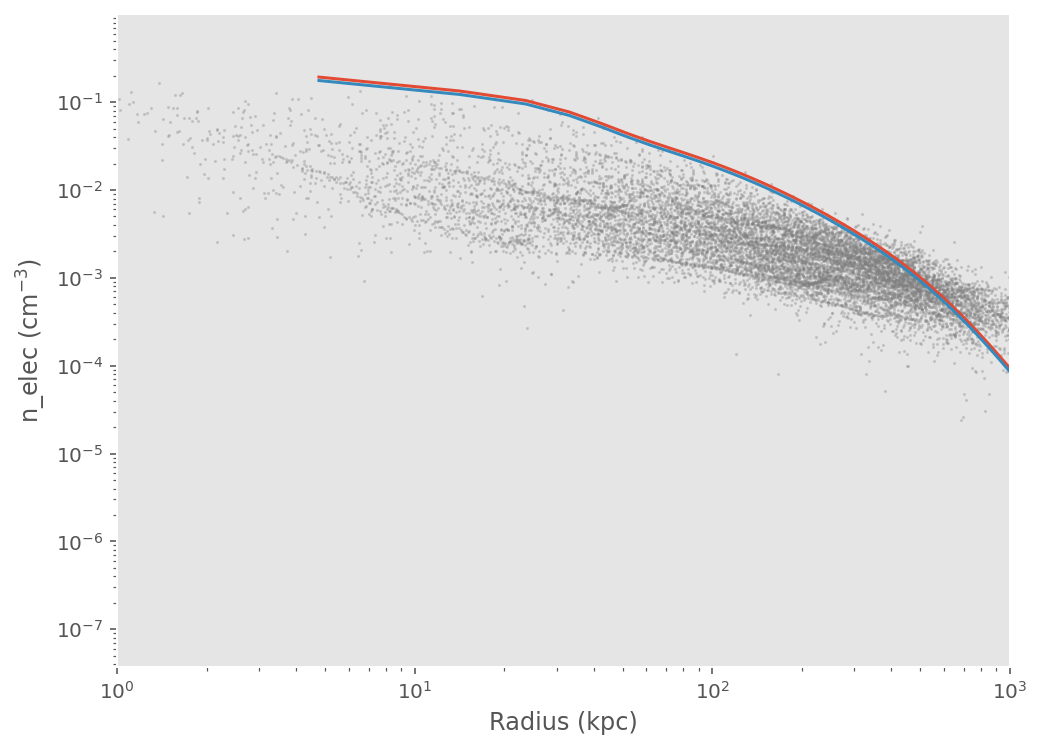

In [115]:
from cmath import sqrt
from socket import SHUT_WR


fig, ax = plt.subplots(figsize=(8,6))

# ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylabel('n_elec (cm$^{-3}$)')
ax.set_xlabel('Radius (kpc)')

# underplot the cooling time profiles for all accept clusters as a comparison! 
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc


    # coeffs = np.polynomial.polynomial.polyfit(accept_radius, cluster_profile['nelec'], deg=2)
    # accept_fit = np.polynomial.polynomial.polyval(tfit_r, coeffs)
    
    # ax.plot(tfit_r, accept_fit, label=cluster_name, color='slategray', alpha=0.05, zorder=0)
    
    ax.plot(accept_radius, cluster_profile['nelec'] , label=cluster_name, zorder=1, alpha=0.3, color='gray', lw=0, marker='o',  markersize=0.6)

ax.plot(r, np.sqrt(1.199*ne_np) * t_kev)
ax.plot(r, sqrt_ne_np * t_kev)

ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_ylim(0,8)
ax.set_xlim(1, 1000)
ax.grid(False)



In [110]:
r = sb_fit_x


regrid_tfitx, regrid_tfity = vikhlinin_temperature_fit(tprof_par_dict, r)
t_kev = regrid_tfity

ne_np = sb_profile_fit['ne_np']
sqrt_ne_np = sb_profile_fit['sqrt(ne_np)']


# Alexey gives us ne * np. To convert this to ne, we assume that 
# ne = sqrt(ne^2) = sqrt(1.199 ne * np) where Z = ne / np = 1.199 is the 
# average nuclear mass for a plasma with 0.3 Zsolar metallicity, assuming abundances 
# from Anders & Grevesse (1989).

# use McDonald Z/3 metallicity values, i.e. 

n_e = np.sqrt(1.199 * ne_np) #  * u.cm**-3
n_p = (1/1.199) * n_e 
n_h = 0.83 * n_e 

pressure_profile = (n_e + n_p) * t_kev # this gives pressure profile that is too high at lower r! 
entropy_profile = t_kev * n_e**(-2/3)


# (3/2 nkT)/(nenpΛ(T,Z))

cooling_time = (3/2 * pressure_profile) / (n_e * n_p * coolingFunction((t_kev)))

Read in the Babyk elliptical profiles

In [40]:
cooling_time_profiles = glob.glob('/Users/grant/Dropbox/ellipticals_sample/*/tcoolpro_*.dat')
cooling_time_names_if_5 = ['Radius (kpc)',  
                      'Tcool (Gyr), projected', 
                      'Tcool_Err (Gyr), projected', 
                      'Tcool (Gyr), deprojected', 
                      'Tcool_Err (Gyr), deprojected']

cooling_time_names_if_6 = ['Radius (kpc)',  
                           'Radius_Err (kpc',
                      'Tcool (Gyr), projected', 
                      'Tcool_Err (Gyr), projected', 
                      'Tcool (Gyr), deprojected', 
                      'Tcool_Err (Gyr), deprojected']

Text(0.5, 1.0, 'Cooling Time')

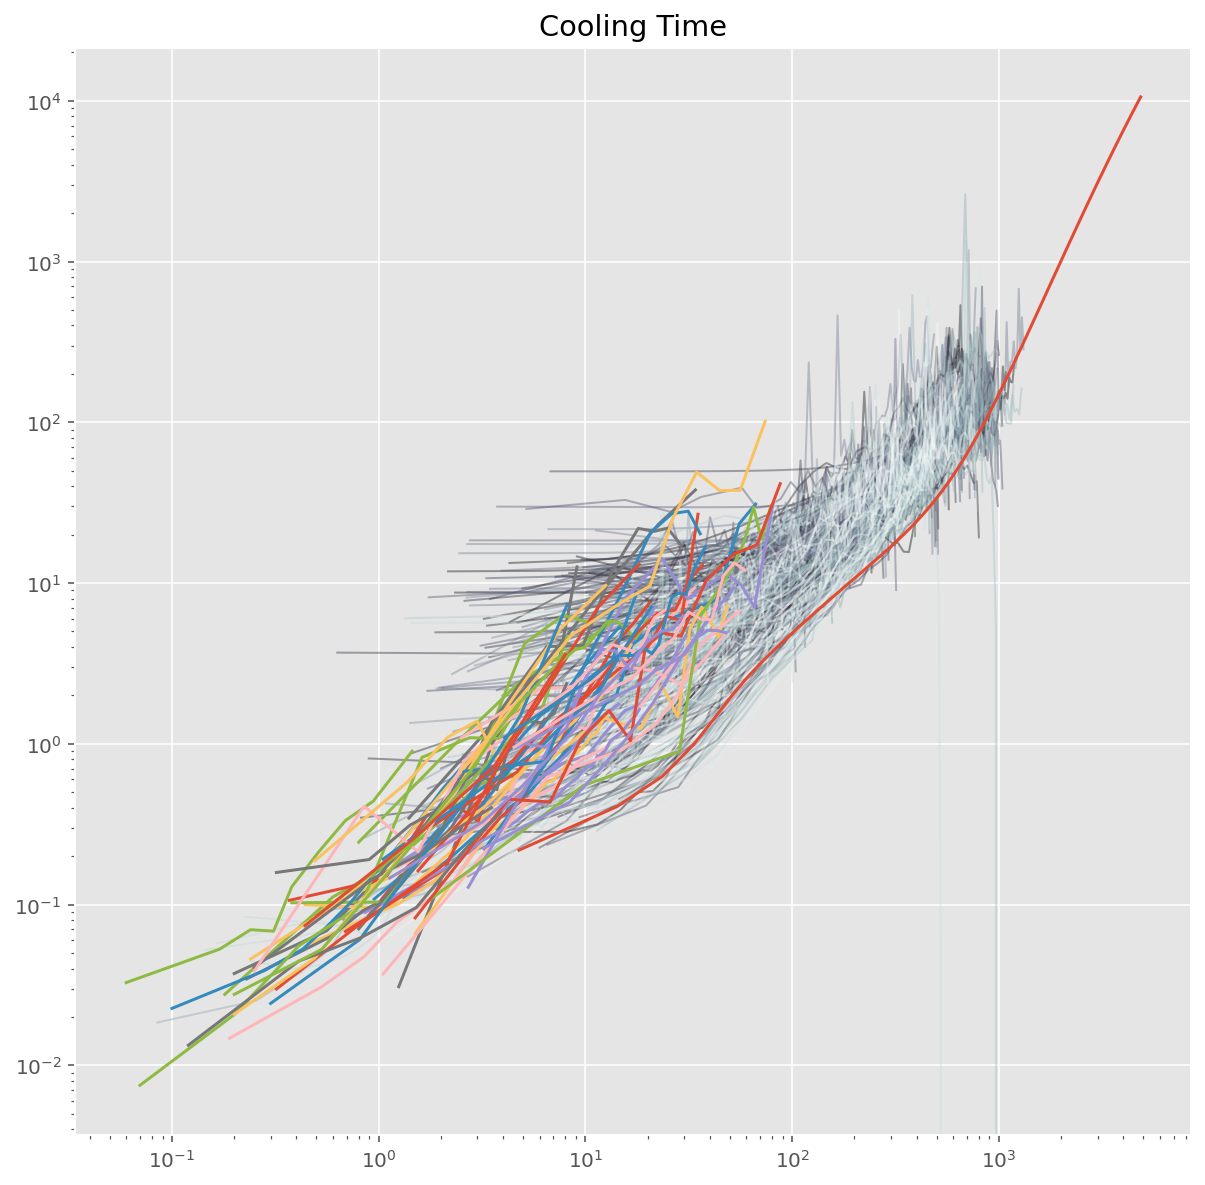

In [43]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r, cooling_time / 3.156e+16 / 1e9, zorder=2)


n = len(accept_table.groups.keys)
colors = sns.color_palette("bone", as_cmap=True)(np.linspace(0,1,n))

# underplot the cooling time profiles for all accept clusters as a comparison! 
for i, (cluster_name, cluster_profile) in enumerate(zip(accept_table.groups.keys, accept_table.groups)):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    min_temperature = np.min(cluster_profile['Tx'])

    
    # coeffs = np.polynomial.polynomial.polyfit(np.log(accept_radius), np.log(cluster_profile['tcool3/2']), deg=3)
    ax.plot(accept_radius, cluster_profile['tcool3/2'] , label=cluster_name, zorder=1, alpha=0.4, color=colors[i], lw=1,  markersize=0.6)


for profile in cooling_time_profiles:
    # These are already in Gyr. Need 
    try: 
        tab = ascii.read(profile)
        if len(tab.colnames) == 5:
            tab = ascii.read(profile, names=cooling_time_names_if_5)
        elif len(tab.colnames) == 6:
            tab = ascii.read(profile, names=cooling_time_names_if_6)

        ax.plot(tab['Radius (kpc)'], tab['Tcool (Gyr), projected'])
    except:
        print('error')
        continue


ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_xlim(1, 800)
# ax.set_ylim(1e8, 1e11)

ax.set_title(r'Cooling Time')

       Rout       
------------------
            1184.0
1163.0500000000002
1142.1000000000001
           1121.15
            1100.2
            1079.2
1058.2500000000002
1037.3000000000002
1016.3500000000001
            995.41
               ...
220.03499999999997
199.07999999999998
178.12499999999997
            157.17
            136.21
           115.255
              94.3
            73.345
             52.39
31.435000000000006
             10.48
Length = 57 rows
       Rout       
------------------
            148.41
            145.15
141.89000000000001
            138.63
           135.365
             132.1
            128.84
            125.58
122.32000000000001
            119.06
               ...
             34.25
30.990000000000002
            27.725
             24.46
              21.2
             17.94
14.680000000000001
             11.42
             8.155
 4.890000000000001
              1.63
Length = 46 rows
       Rout       
------------------
 571.49999999999

Text(0.5, 1.0, 'Entropy')

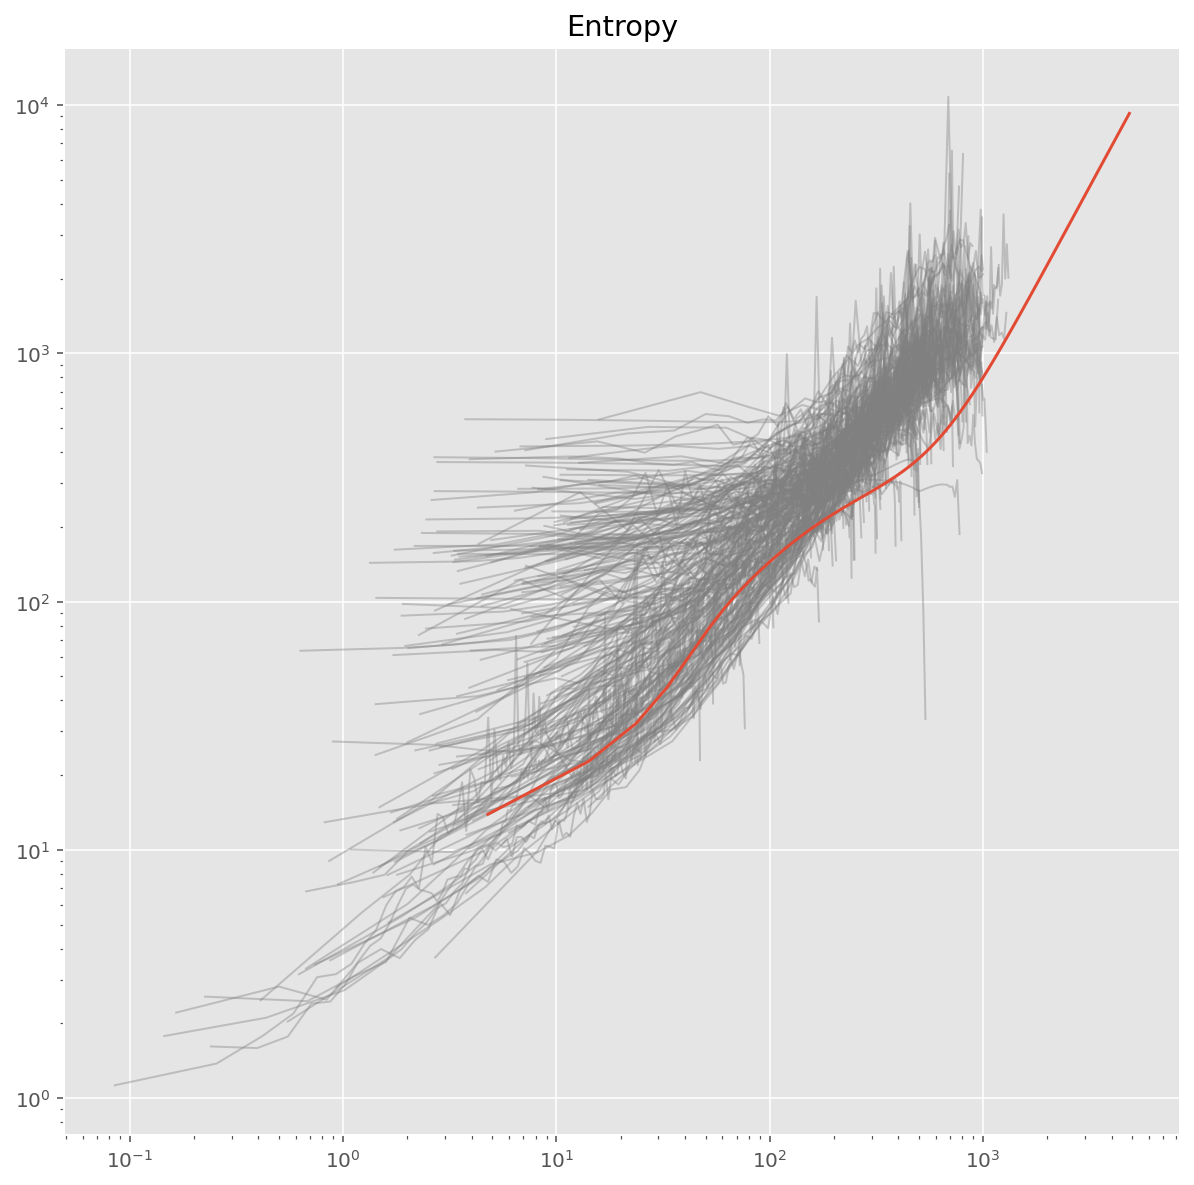

In [20]:
fig, ax = plt.subplots(figsize=(10,10))

# ax.plot(r, cooling_time/ 3.156e+16, zorder=2)

# underplot the cooling time profiles for all accept clusters as a comparison! 
for cluster_name, cluster_profile in zip(accept_table.groups.keys, accept_table.groups):
    accept_radius = ((cluster_profile['Rout'] + cluster_profile['Rin']) / 2) * 1000 # Table radii are in Mpc
    mean_temperature = np.sum(cluster_profile['Tx'])


    ax.plot(accept_radius, cluster_profile['Kitpl'], label=cluster_name, zorder=1, alpha=0.4, color='gray', lw=1)
    print(accept_radius)

ax.plot(r, entropy_profile)

ax.set_yscale('log')
ax.set_xscale('log')

# ax.set_xlim(1, 1000)
# ax.set_ylim(1, 10)

ax.set_title(r'Entropy')

Text(0.5, 0, 'Radius (kpc h$_{70}^{-1}$)')

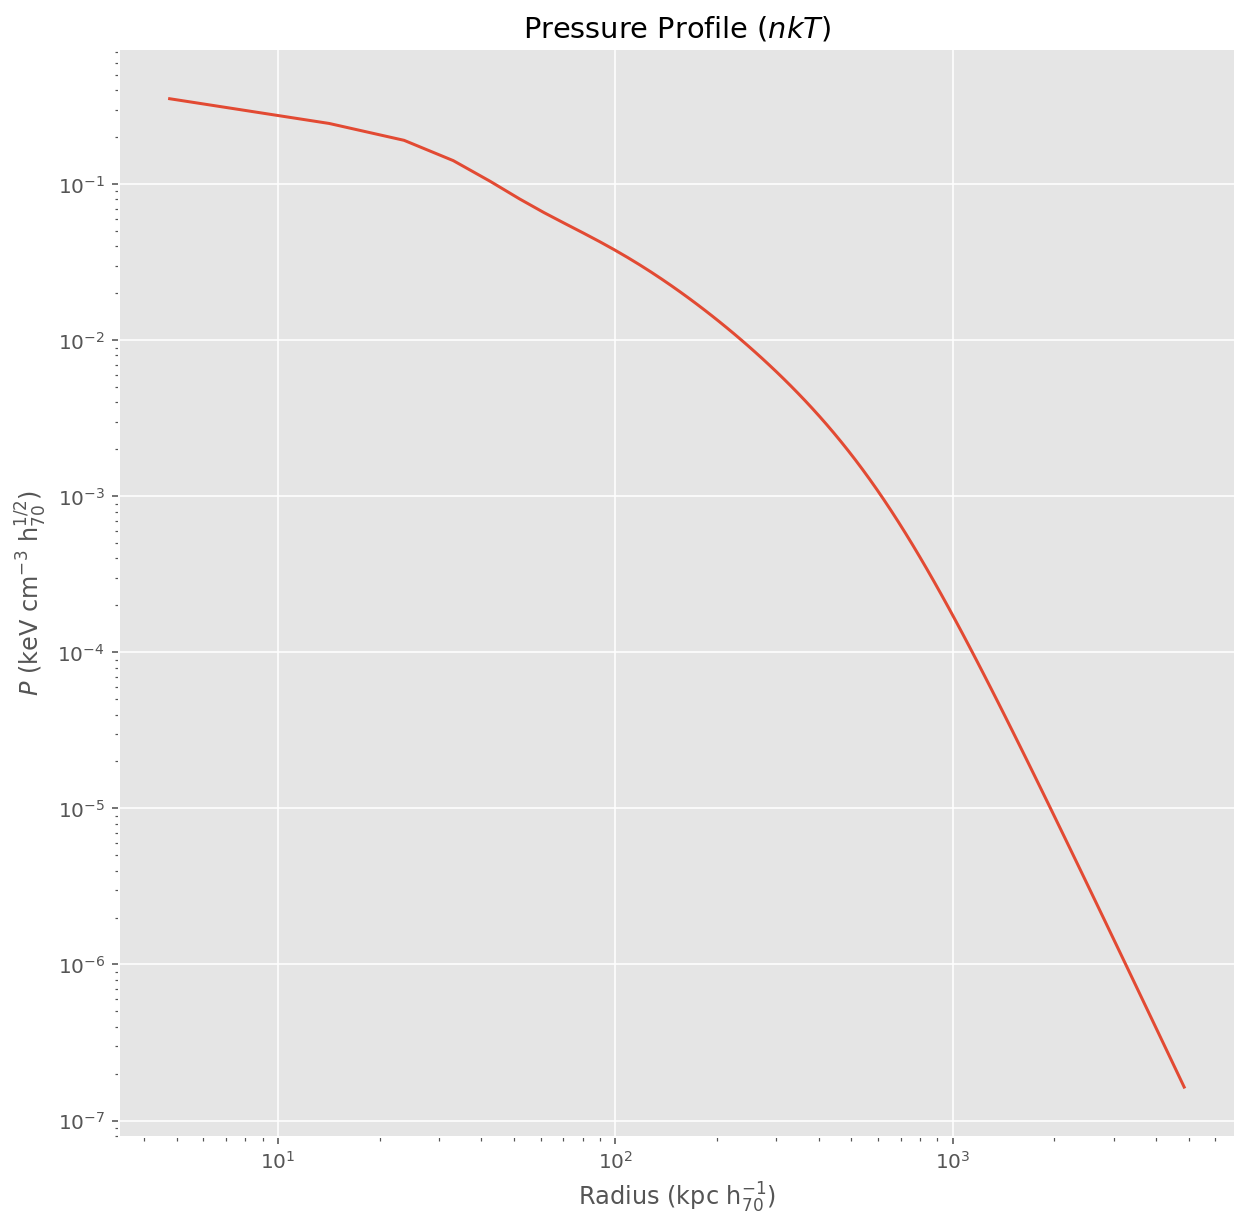

In [21]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r, pressure_profile)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(r'Pressure Profile ($nkT$)')
ax.set_ylabel(r'$P$ (keV cm$^{-3}$ h$_{70}^{1/2}$)')
ax.set_xlabel(r'Radius (kpc h$_{70}^{-1}$)')

This is consistent with the Arnaud +10 universal pressure profiles 

Text(0.5, 0, 'Radius (kpc h$_{70}^{-1}$)')

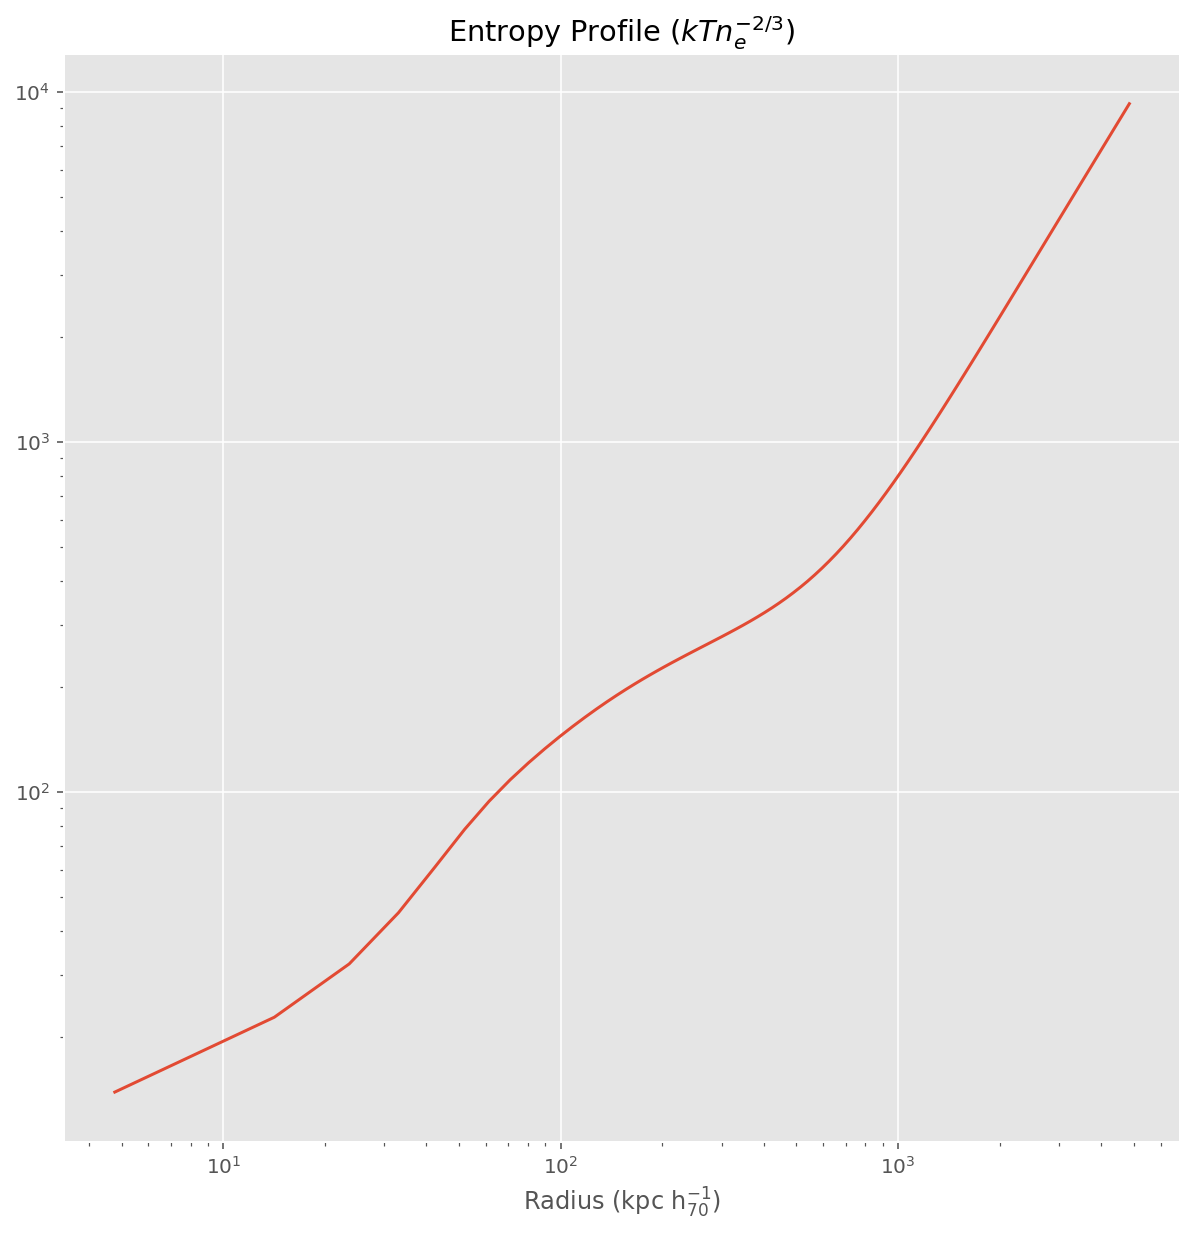

In [22]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r, entropy_profile)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title(r'Entropy Profile ($kT n_e^{-2/3}$)')
# ax.set_ylabel(r'$P$ (keV cm$^{-3}$ h$_{70}^{1/2}$)')
ax.set_xlabel(r'Radius (kpc h$_{70}^{-1}$)')

Text(0.5, 0, 'Radius (kpc h$_{70}^{-1}$)')

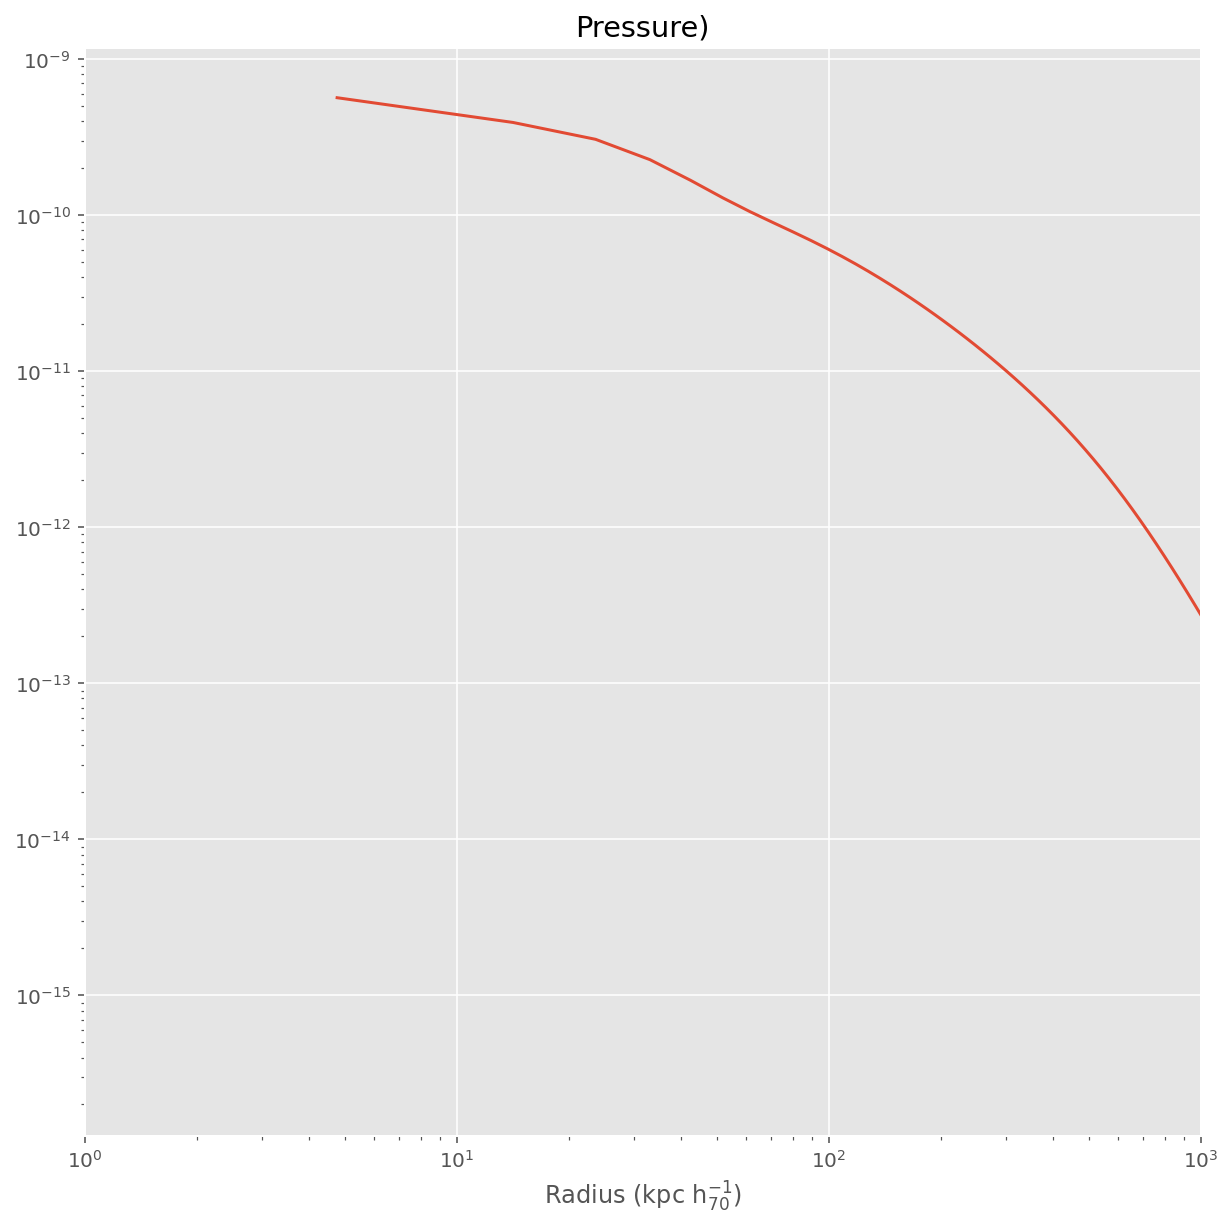

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r, pressure_profile*1.60218e-9)
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim(1,1000)

ax.set_title(r'Pressure)')
# ax.set_ylabel(r'$P$ (keV cm$^{-3}$ h$_{70}^{1/2}$)')
ax.set_xlabel(r'Radius (kpc h$_{70}^{-1}$)')

Text(0.5, 0, 'Radius (kpc)')

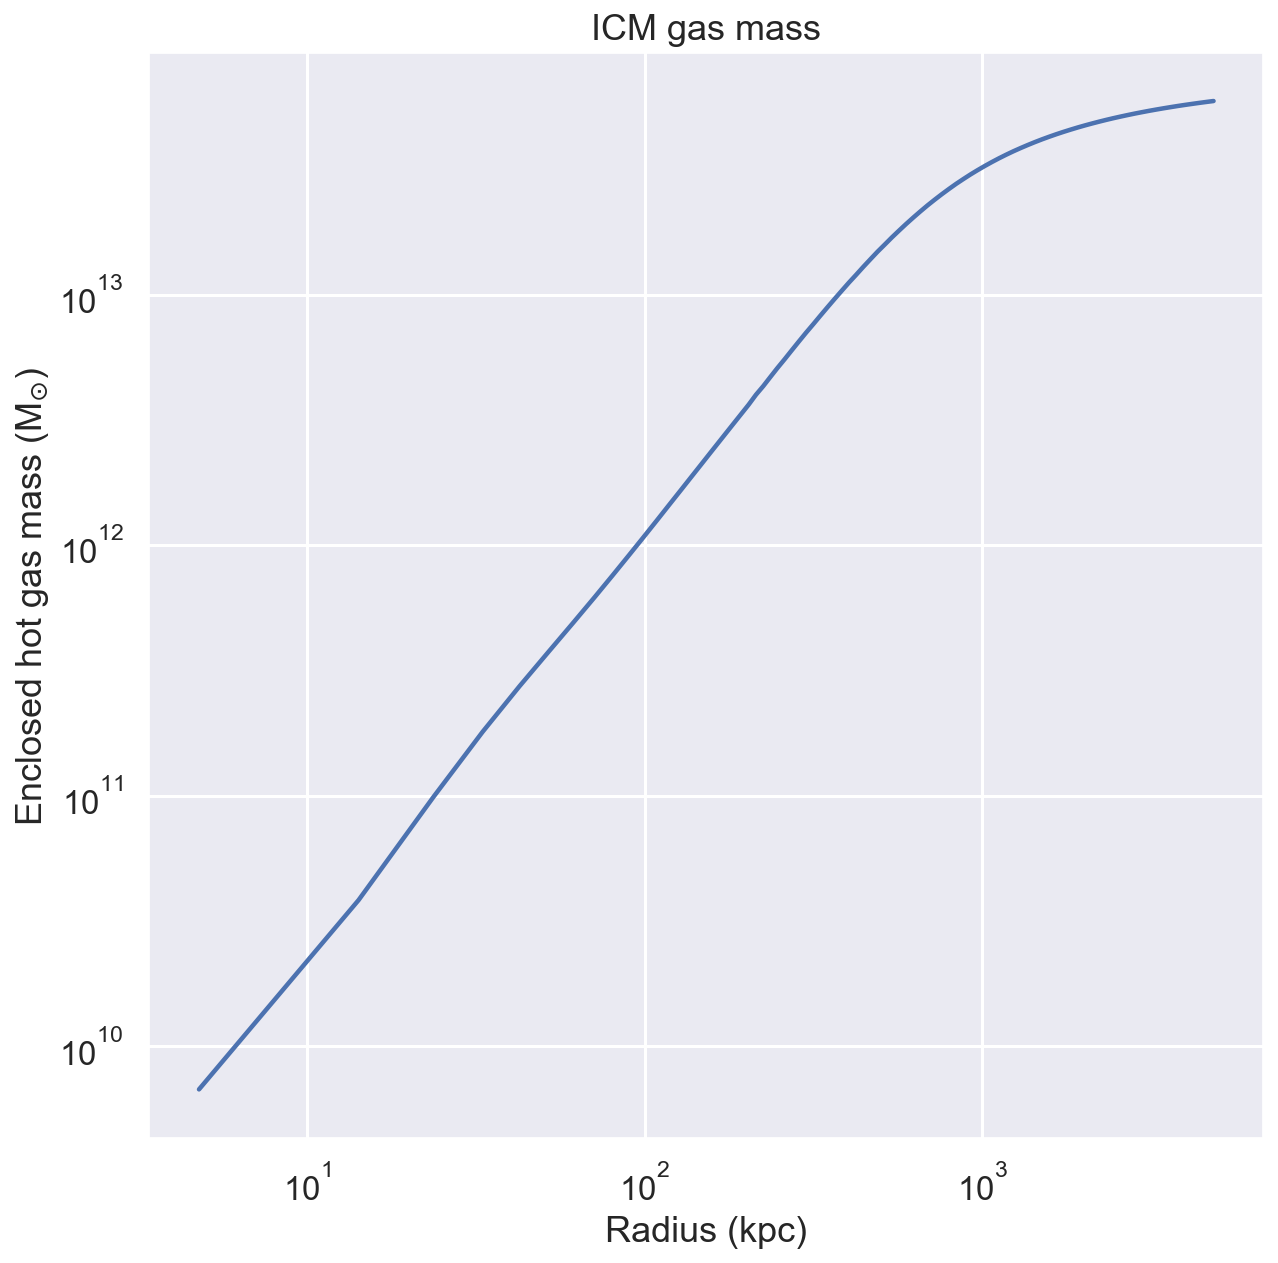

In [605]:
fig, ax = plt.subplots(figsize=(10,10))

x = sb_profile_fit['R']
y = sb_profile_fit['gas_mass']

ax.plot(x,y)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_title('ICM gas mass')
ax.set_ylabel(r'Enclosed hot gas mass (M$_{\odot}$)')
ax.set_xlabel(r'Radius (kpc)')

Text(0.5, 0, 'Radius (kpc)')

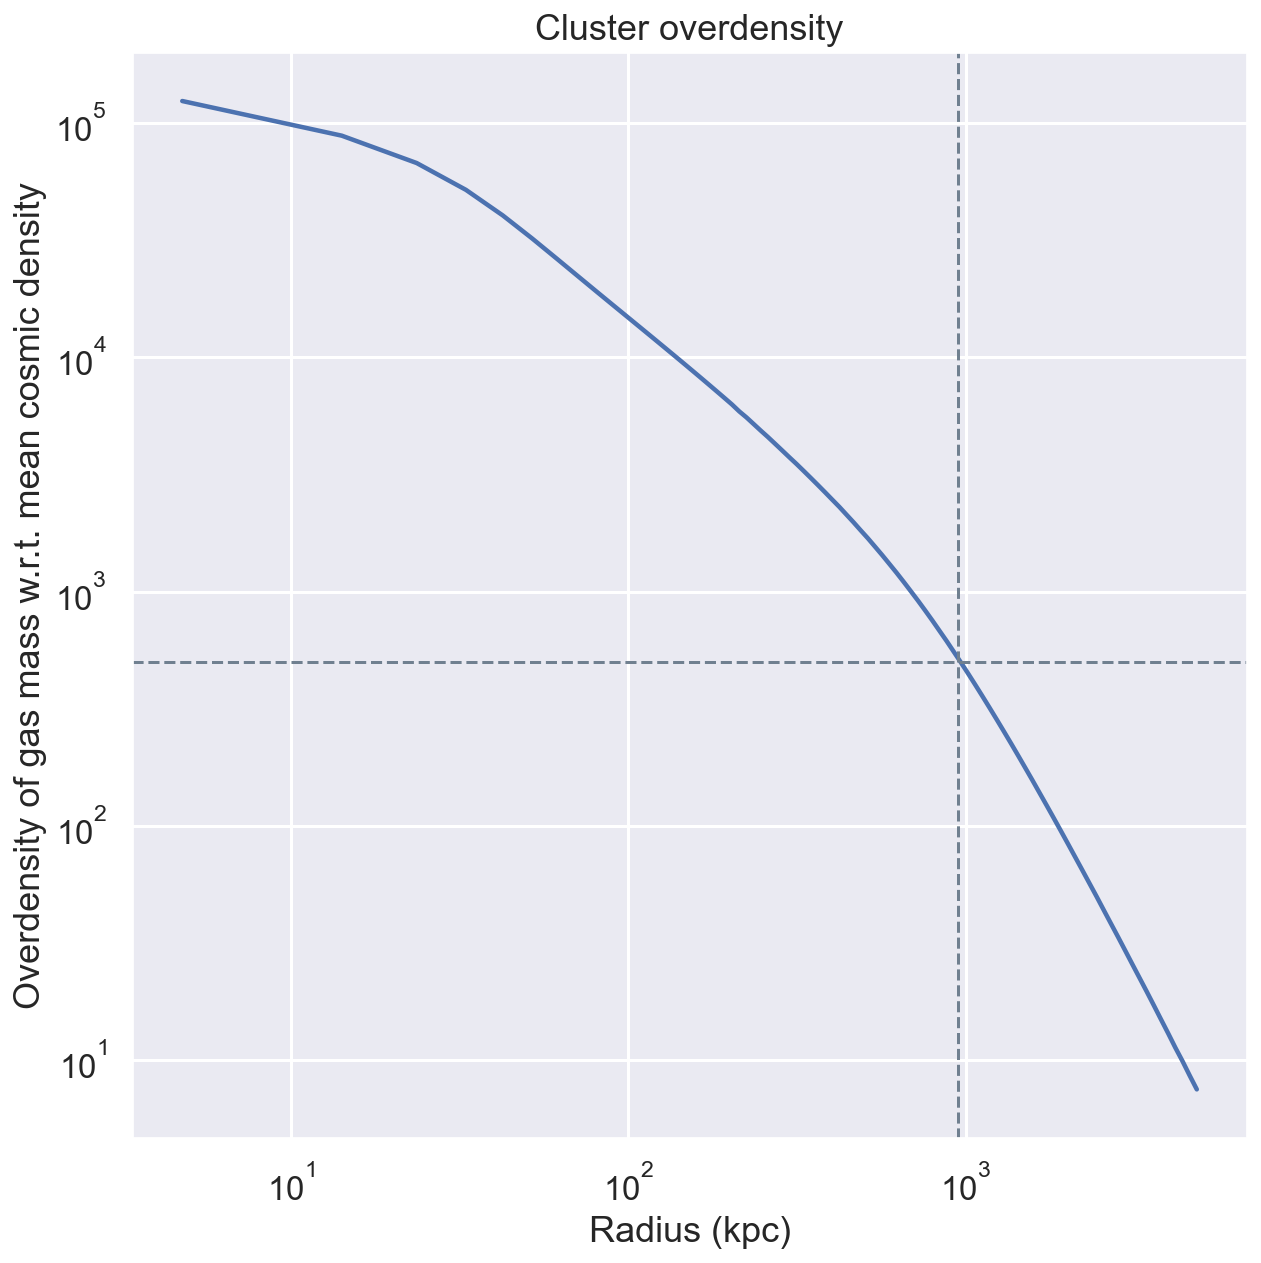

In [606]:
fig, ax = plt.subplots(figsize=(10,10))

ax.plot(r,sb_profile_fit['spherical_overdensity'])

ax.set_yscale('log')
ax.set_xscale('log')

ax.axvline(950, color='slategray', ls='--', lw=1.5) 
ax.axhline(500,  color='slategray', ls='--', lw=1.5)

ax.set_title('Cluster overdensity')
ax.set_ylabel(r'Overdensity of gas mass w.r.t. mean cosmic density')
ax.set_xlabel(r'Radius (kpc)')